In [1]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_spectrum
import multiprocessing
import pandas as pd
from functools import partial
import numpy as np
import glob
import re
import csv
import seaborn as sns
import pandas as pd

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms
#sns.set(style="ticks", context="talk", font_scale=1.0)

plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# redshift

In [5]:
type1zs =  pd.read_csv('../type1-z02-zs-3800-7500-redshifted-normalized.csv', header=None, comment='#').values.tolist()[0]
type2zs =  pd.read_csv('../sy20-dr7-zs-3800-7500-redshifted-normalized-10000.csv', header=None, comment='#').values.tolist()[0]

sy19zs_train =  pd.read_csv('../sy19-zs-3800-7500-redshifted-normalized.csv', header=None, comment='#').values.tolist()[0]
sy19zs_test =  pd.read_csv('../sy19-test-zs-3800-7500-redshifted-normalized.csv', header=None, comment='#').values.tolist()[0]

type1zs = type1zs + sy19zs_train + sy19zs_test
type2zs = type2zs[int(0.5*len(type1zs)):int(1.5*len(type1zs))]


In [1]:
fig = plt.figure(figsize=(8,6))

plt.hist(type1zs,np.linspace(0,0.2,41),color='C2',alpha=1, label='Type I:  mean = 0.119, std = 0.044')
plt.hist(type2zs,np.linspace(0,0.2,41),color='C0',alpha=0.9, label='Type II: mean = 0.121, std = 0.044')
#plt.hist(sy19zs_train+sy19zs_test,np.linspace(0,0.2,201),color='C1',alpha=0.95, label='Type 2: mean = 0.122, std = 0.044')

#from scipy.stats import lognorm
#shape,loc,scale = lognorm.fit(type1zs)
#x = np.linspace(0,0.2,101)
#pdf = lognorm.pdf(x, shape, loc, scale)
#plt.plot(x, 7.3*pdf, 'C2')

#shape,loc,scale = lognorm.fit(type2zs)
#x = np.linspace(0,0.2,41)
#pdf = lognorm.pdf(x, 0.0488, -0.918, scale)
#pdf = lognorm.pdf(x, shape, loc, scale)
#plt.plot(x, 18*pdf, 'C1')

#plt.hist(QSOTypeI['Z'],50,alpha=0.4)
plt.xlim(0,0.2)
plt.legend(loc=4, fontsize = 10)
plt.xlabel('Redshift (z)', fontsize = 12)
plt.ylabel('Number of galaxies (per $\Delta z = 0.005$)', fontsize = 12)

fig.tight_layout()
plt.savefig('redshift-distribution-type1-type2.pdf', format='pdf')

NameError: name 'plt' is not defined

# Normalized Data Variability

## define functions

In [34]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def plotData(data,label='',color=None, alpha=1, linewidth=1, wavelengths=None, zorder=1):
    if wavelengths is None:
        wavelengths = np.linspace(3800,len(data)-1+3800,len(data))
    if color is None:
        plt.plot(wavelengths, data.tolist(),\
                 alpha=alpha, linewidth = linewidth, label=label,zorder=zorder)
    else:
        plt.plot(wavelengths, data.tolist(),\
                 alpha=alpha, color=color, linewidth = linewidth, label=label, zorder=zorder)
        
def plotFilters(filters):
    filters = filters.flatten()[1:-1].reshape(-1,2)
    for x in filters:
        plt.axvspan(x[0]+3800, x[1]+3800, alpha=0.5, facecolor='grey')
        
def sizeMap(inputSize):
    IN = inputSize
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    C3 = (S2-50)+1
    S4 = int(C3/2)
    return IN, C1, S2, C3, S4


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list

In [3]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
type1 = read_data('../type1-z02-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20 = read_data('../sy20-dr7-pixels-3800-7500-redshifted-normalized-10000.csv', delimiter=',')
sy19 = read_data('../sy19-dr7-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')

   
## Full sample
## size of filtered spectrum 2079
##size of original spectrum 3701
type1_feature = torch.Tensor(np.concatenate((sy19,type1), axis=0)).view(-1,3701)
type2_feature = torch.Tensor(sy20).view(-1,3701)

In [6]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
type1_filtered = read_data('../type1-z02-pixels-3800-7500-redshifted-lines-filtered-normalized.csv', delimiter=',')
sy20_filtered = read_data('../sy20-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized-10000.csv', delimiter=',')
sy19_filtered = read_data('../sy19-dr7-pixels-3800-7500-redshifted-lines-filtered-normalized.csv', delimiter=',')

## Full sample
## size of filtered spectrum 2079
##size of original spectrum 3701

type1_feature_filtered = torch.Tensor(np.concatenate((sy19_filtered, type1_filtered), axis=0)).view(-1,2021)
type2_feature_filtered = torch.Tensor(sy20_filtered).view(-1,2021)

In [7]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
type1_raw = read_data('../type1-z02-pixels-3800-7500-redshifted-original.csv', delimiter=',')
sy20_raw = read_data('../sy20-dr7-pixels-3800-7500-redshifted-original-10000.csv', delimiter=',')
sy19_raw = read_data('../sy19-dr7-pixels-3800-7500-redshifted-original.csv', delimiter=',')

   
## Full sample
## size of filtered spectrum 2079
##size of original spectrum 3701
type1_feature_raw = torch.Tensor(np.concatenate((sy19_raw,type1_raw), axis=0)).view(-1,3701)
type2_feature_raw = torch.Tensor(sy20_raw).view(-1,3701)

## Compute Variability

In [8]:
def histogram_intersection(h1, h2):
    y1 = h1[0]
    y2 = h2[0]
    x1 = h1[1][1:]-h1[1][:-1]
    x2 = h2[1][1:]-h2[1][:-1]
    h1Total = 0
    h2Total = 0
    inTotal = 0
    for i in range(len(y1)):
        h1Total += y1[i]*x1[i]
        h2Total += y2[i]*x2[i]
        inTotal += min(y1[i]*x1[i], y2[i]*x2[i])
    return h1Total, h2Total, inTotal


def _powerLaw(x, amp, index, ePiv):
    return amp * (x/ePiv)**index

In [179]:
type1_std = np.array([x.std().item() for x in type1_feature])
#type1_org_noise_std = np.array([x.std().item() for x in type1_feature_noise])
type2_std = np.array([x.std().item() for x in type2_feature])


type1_std_filtered = np.array([x.std().item() for x in type1_feature_filtered])
#type1_noise_std = np.array([x.std().item() for x in type1_feature_noise_filtered])
type2_std_filtered = np.array([x.std().item() for x in type2_feature_filtered])

type1_std_raw = np.array([x.std().item() for x in type1_feature_raw])
#type1_noise_std = np.array([x.std().item() for x in type1_feature_noise_filtered])
type2_std_raw = np.array([x.std().item() for x in type2_feature_raw])

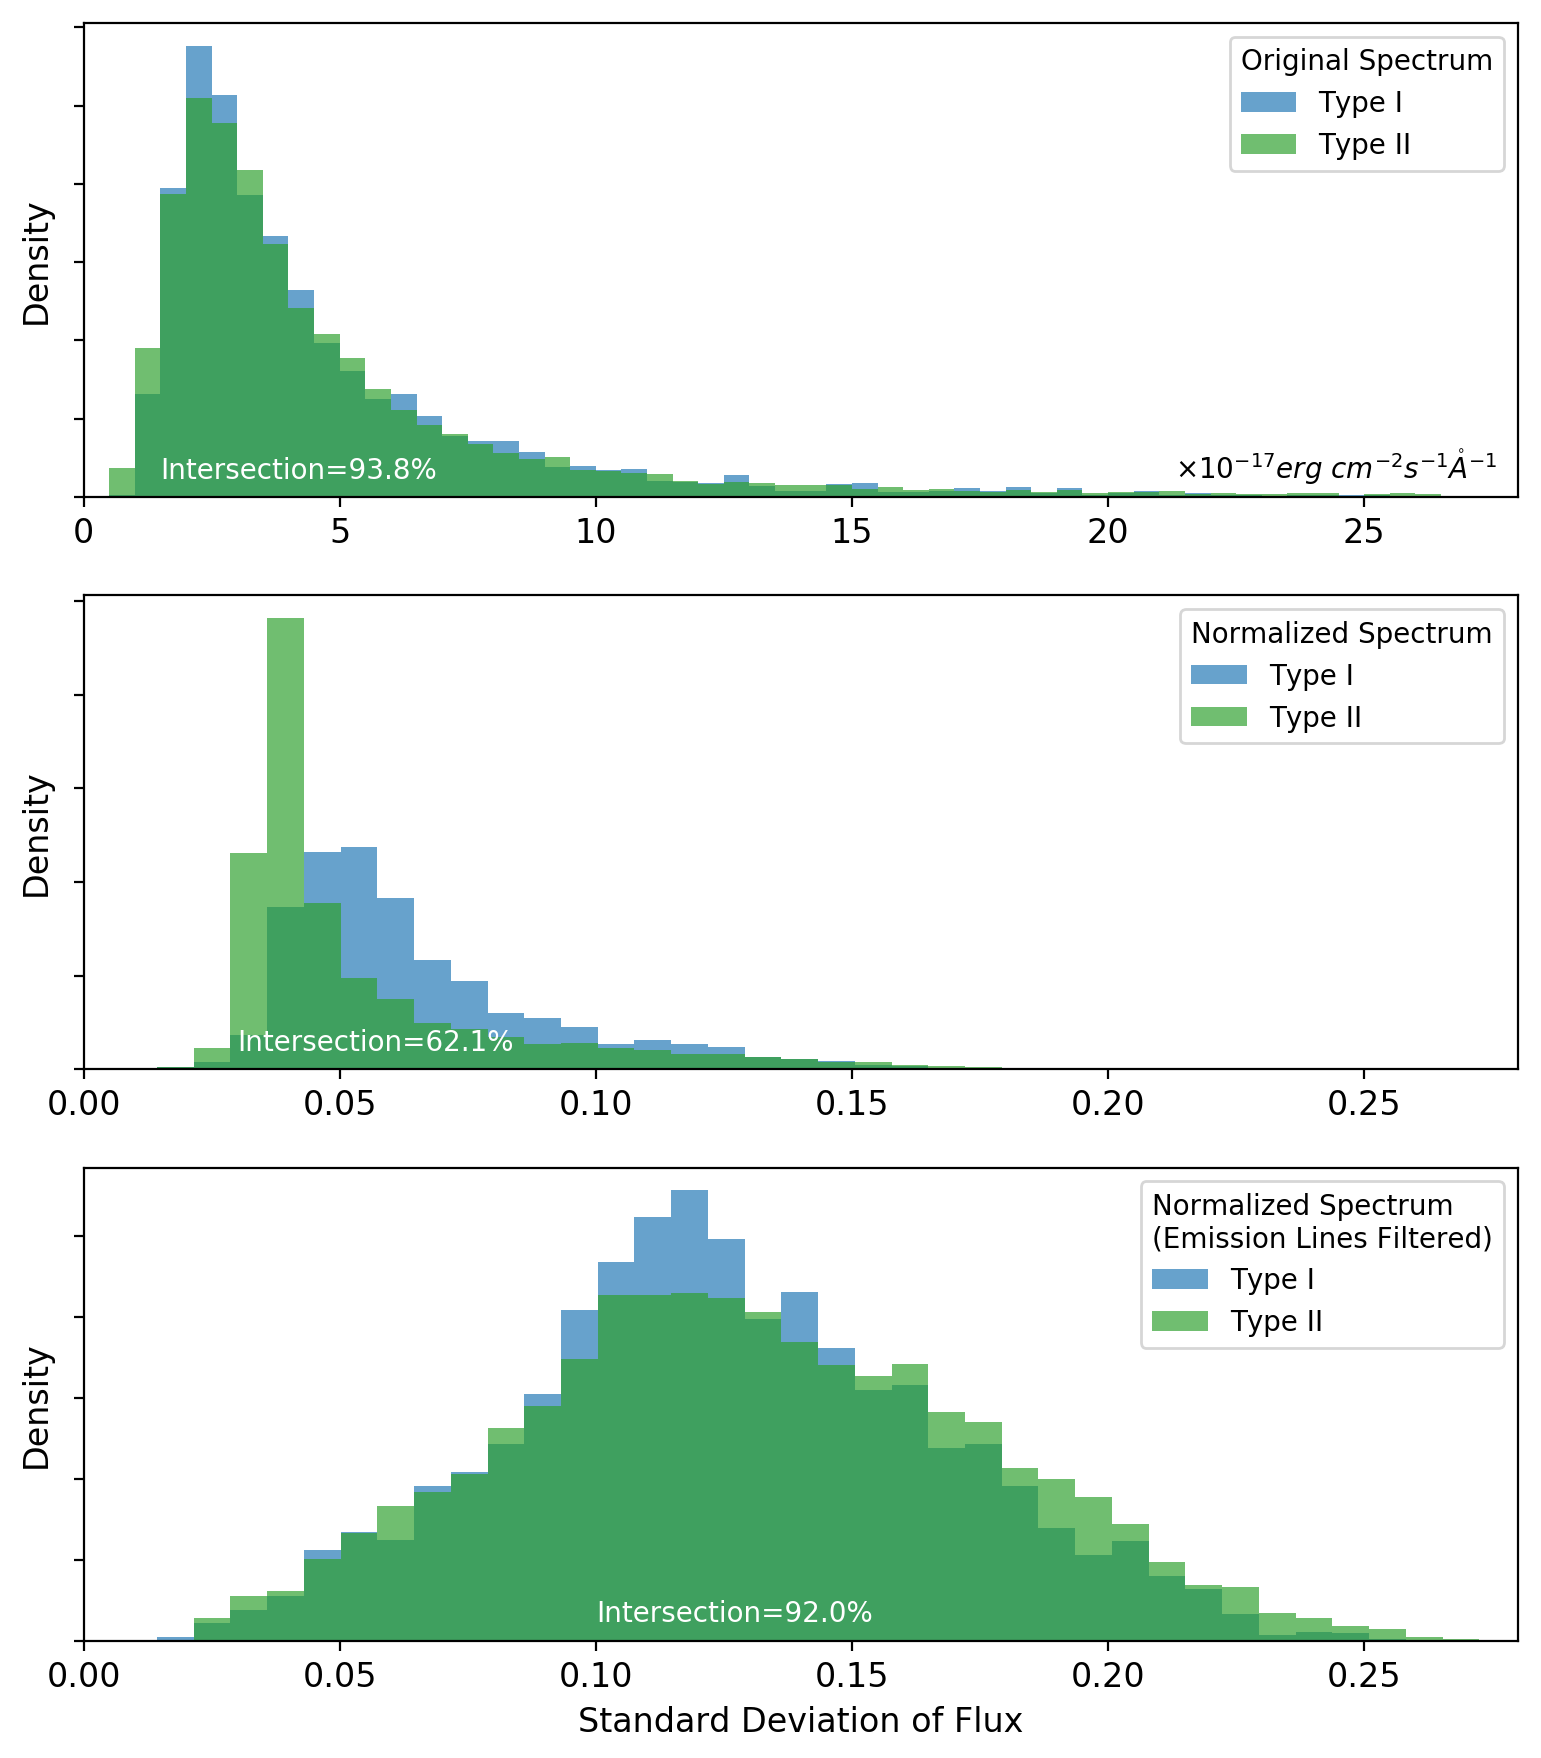

In [219]:
# Normalize

bins1 = np.linspace(0,26.5,54)
kwargs1 = dict(alpha=0.68, bins=bins1, density=True, stacked=True)
bins2 = np.linspace(0,0.38,54)
kwargs2 = dict(alpha=0.68, bins=bins2, density=True, stacked=True)


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,9), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace = 0.05)

plt.sca(axs[0])
axs[0].set_yticklabels([])
type1_hist = plt.hist(type1_std_raw, **kwargs1, color='C0', label='Type I')
type2_hist = plt.hist(type2_std_raw, **kwargs1, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist,type2_hist),3)[2]*100
plt.text(1.5, 0.012, '\nIntersection='+str(round(intersection,2))+'%', color='#ffffff', fontsize=10)
plt.text(21.3, 0.012, '$\\times 10^{-17}erg$ $cm^{-2}$$s^{-1}$$\mathring{A}^{-1}$', color='#000000', fontsize=10)
plt.xlim(0,28)

leg = plt.legend(title = 'Original Spectrum', loc=1, fontsize=10)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.ylabel('Density')

plt.sca(axs[1])
axs[1].set_yticklabels([])
type1_hist = plt.hist(type1_std, **kwargs2, color='C0', label='Type I')
type2_hist = plt.hist(type2_std, **kwargs2, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist,type2_hist),3)[2]*100
plt.text(0.03, 2, '\nIntersection='+str(round(intersection,2))+'%', color='#ffffff', fontsize=10)
leg = plt.legend(title = 'Normalized Spectrum', loc=1, fontsize=10)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(0,0.28)
plt.ylabel('Density')
    
plt.sca(axs[2])
axs[2].set_yticklabels([])
type1_hist_filtered = plt.hist(type1_std_filtered, **kwargs2, color='C0', label='Type I')
type2_hist_filtered = plt.hist(type2_std_filtered, **kwargs2, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist_filtered,type2_hist_filtered),3)[2]*100
plt.text(0.1, 0.5, '\nIntersection='+str(round(intersection))+'%', color='#ffffff', fontsize=10)
leg = plt.legend(loc=1, fontsize=10, title = 'Normalized Spectrum\n(Emission Lines Filtered)')
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(0,0.28)

plt.xlabel('Standard Deviation of Flux')
plt.ylabel('Density')

fig.tight_layout()
plt.savefig('std_spectrum.pdf', format='pdf')

normalzied specetrum takes mminimal and maximum, so influenced by the maximun, it seems Type II has higher maximum value.

The filtered one returns back to the original one, it shows we have successfully filtered all the lines.

In [215]:
type1_mean = np.array([x.mean().item() for x in type1_feature])
#type1_org_noise_mean = np.array([x.mean().item() for x in type1_feature_noise])
type2_mean = np.array([x.mean().item() for x in type2_feature])


type1_mean_filtered = np.array([x.mean().item() for x in type1_feature_filtered])
#type1_noise_mean = np.array([x.mean().item() for x in type1_feature_noise_filtered])
type2_mean_filtered = np.array([x.mean().item() for x in type2_feature_filtered])

type1_mean_raw = np.array([x.mean().item() for x in type1_feature_raw])
#type1_noise_mean = np.array([x.mean().item() for x in type1_feature_noise_filtered])
type2_mean_raw = np.array([x.mean().item() for x in type2_feature_raw])

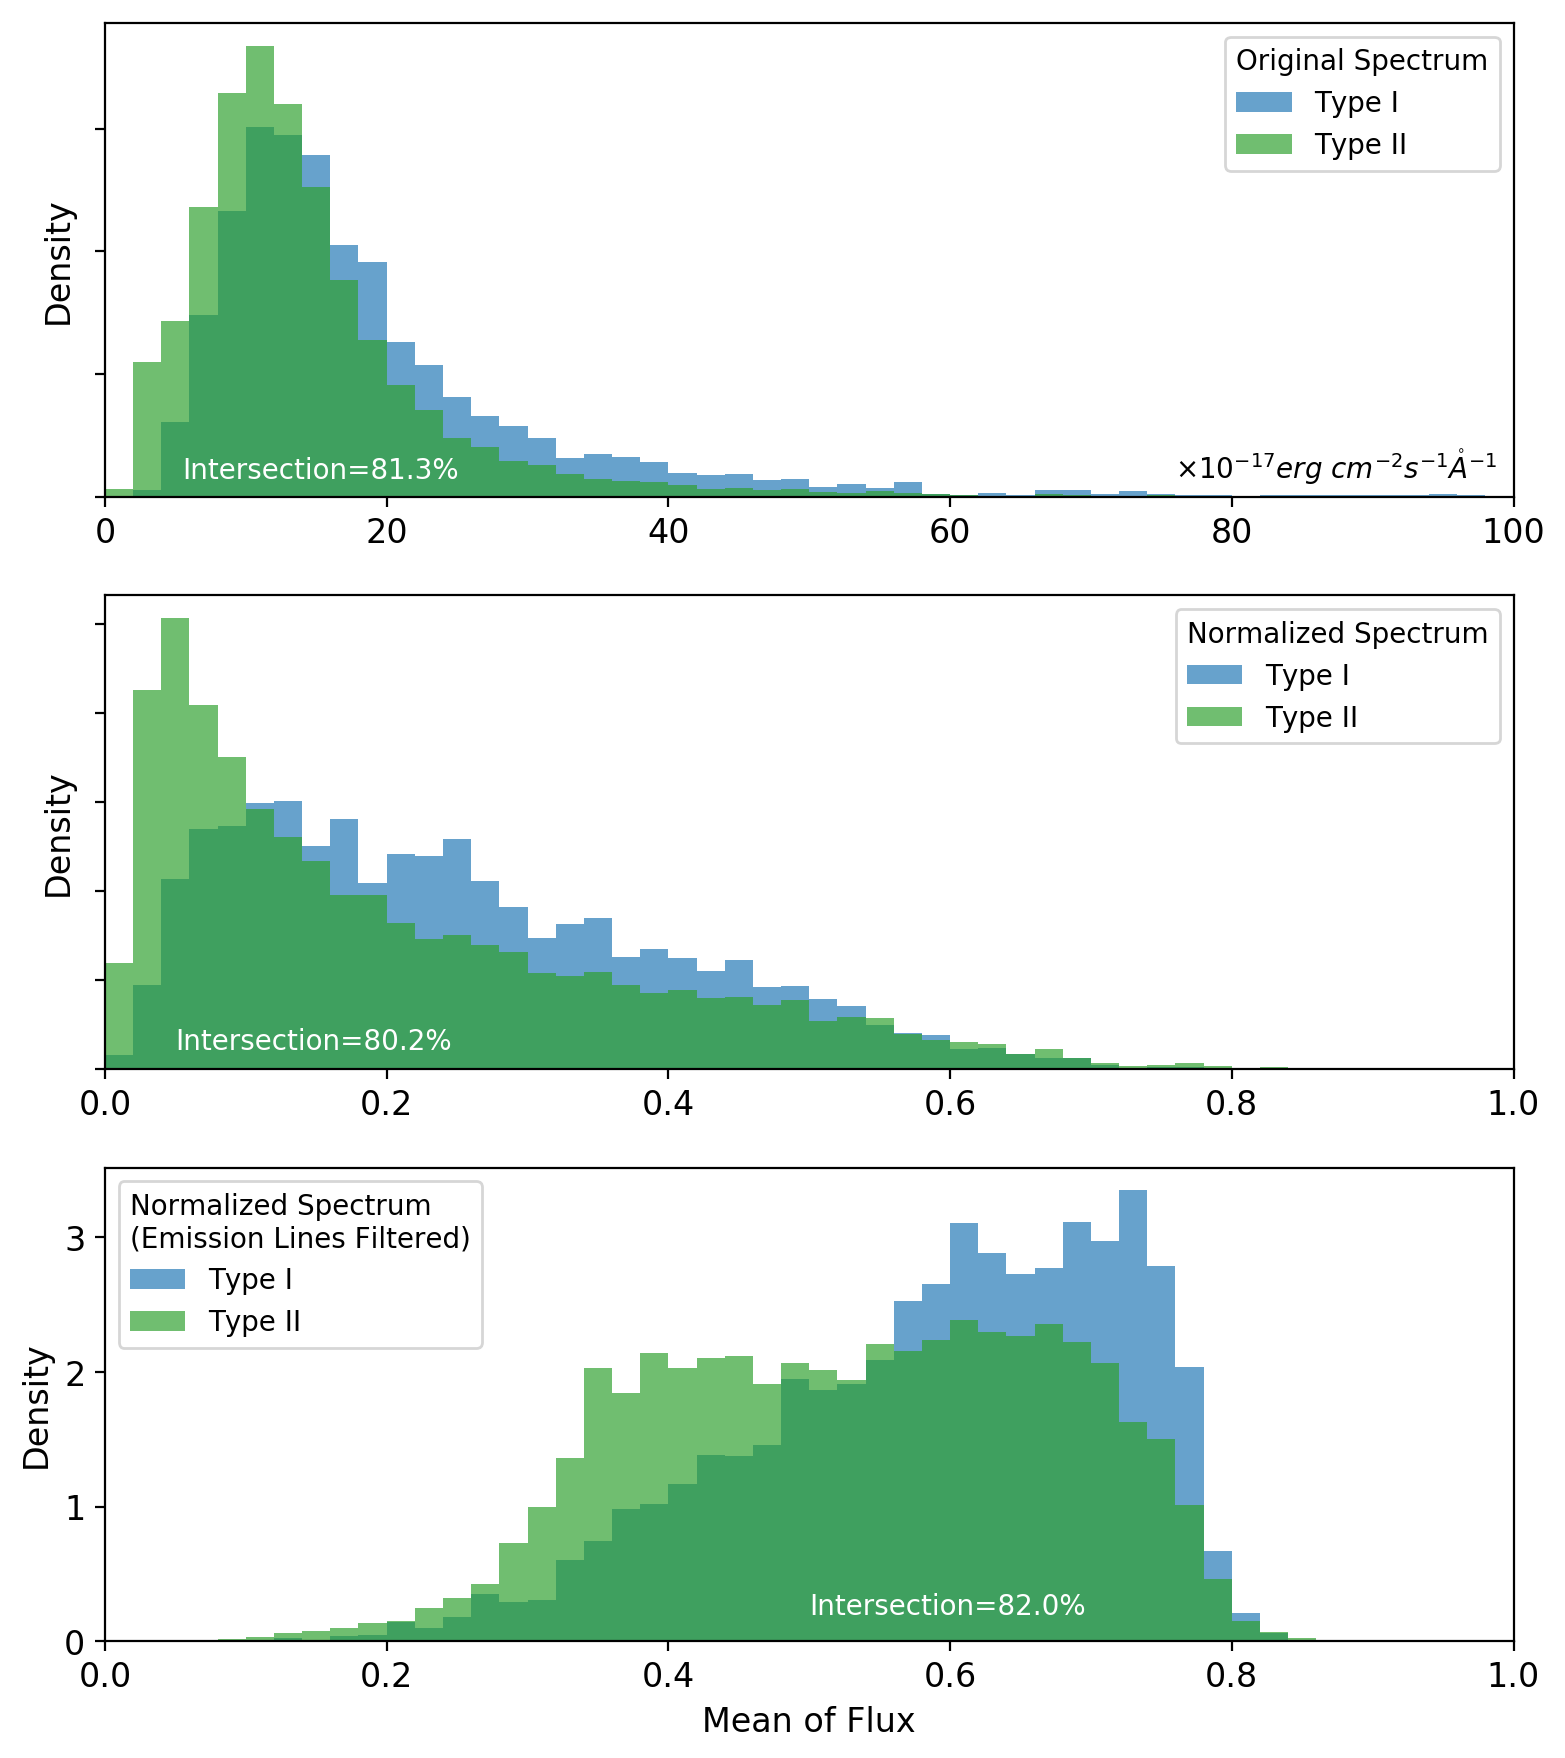

In [222]:
# Normalize
bins1 = np.linspace(0,100,51)
kwargs1 = dict(alpha=0.68, bins=bins1, density=True, stacked=True)
bins2 = np.linspace(0,1,51)
kwargs2 = dict(alpha=0.68, bins=bins2, density=True, stacked=True)


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,9), sharex=False, sharey=False)
plt.subplots_adjust(hspace=0.05, wspace = 0.05)

plt.sca(axs[0])
axs[0].set_yticklabels([])
type1_hist = plt.hist(type1_mean_raw, **kwargs1, color='C0', label='Type I')
type2_hist = plt.hist(type2_mean_raw, **kwargs1, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist,type2_hist),3)[2]*100
plt.text(5.5, 0.003, '\nIntersection='+str(round(intersection,2))+'%', color='#ffffff', fontsize=10)
plt.text(76, 0.003, '$\\times 10^{-17}erg$ $cm^{-2}$$s^{-1}$$\mathring{A}^{-1}$', color='#000000', fontsize=10)
plt.xlim(0,100)

leg = plt.legend(title = 'Original Spectrum', loc=1, fontsize=10)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.ylabel('Density')

plt.sca(axs[1])
axs[0].set_yticklabels([])
type1_hist = plt.hist(type1_mean, **kwargs2, color='C0', label='Type I')
type2_hist = plt.hist(type2_mean, **kwargs2, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist,type2_hist),3)[2]*100
plt.text(0.05, 0.225, '\nIntersection='+str(round(intersection,2))+'%', color='#ffffff', fontsize=10)
leg = plt.legend(title = 'Normalized Spectrum', loc=1, fontsize=10)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(0,1)
plt.ylabel('Density')
    
plt.sca(axs[2])
axs[1].set_yticklabels([])
type1_hist_filtered = plt.hist(type1_mean_filtered, **kwargs2, color='C0', label='Type I')
type2_hist_filtered = plt.hist(type2_mean_filtered, **kwargs2, color='C2', label='Type II')
intersection = np.round(histogram_intersection(type1_hist_filtered,type2_hist_filtered),3)[2]*100
plt.text(0.5, 0.2, '\nIntersection='+str(round(intersection))+'%', color='#ffffff', fontsize=10)
leg = plt.legend(loc=2, fontsize=10, title = 'Normalized Spectrum\n(Emission Lines Filtered)')
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(0,1)

plt.xlabel('Mean of Flux')
plt.ylabel('Density')

fig.tight_layout()
plt.savefig('mean_spectrum.pdf', format='pdf')

lines contribute a small portion of the entire spectrum, filtering lines does not change very much the mean value.

# Minimal and Maximun Varibility 

In [37]:
type2_std_temp = type2_std[:2000]
type1_std_temp = type1_std[:500]
type2_min_index, type2_max_index = np.argmin(type2_std_temp),np.argmax(type2_std_temp)
type1_min_index, type1_max_index = np.argmin(type1_std_temp),np.argmax(type1_std_temp)

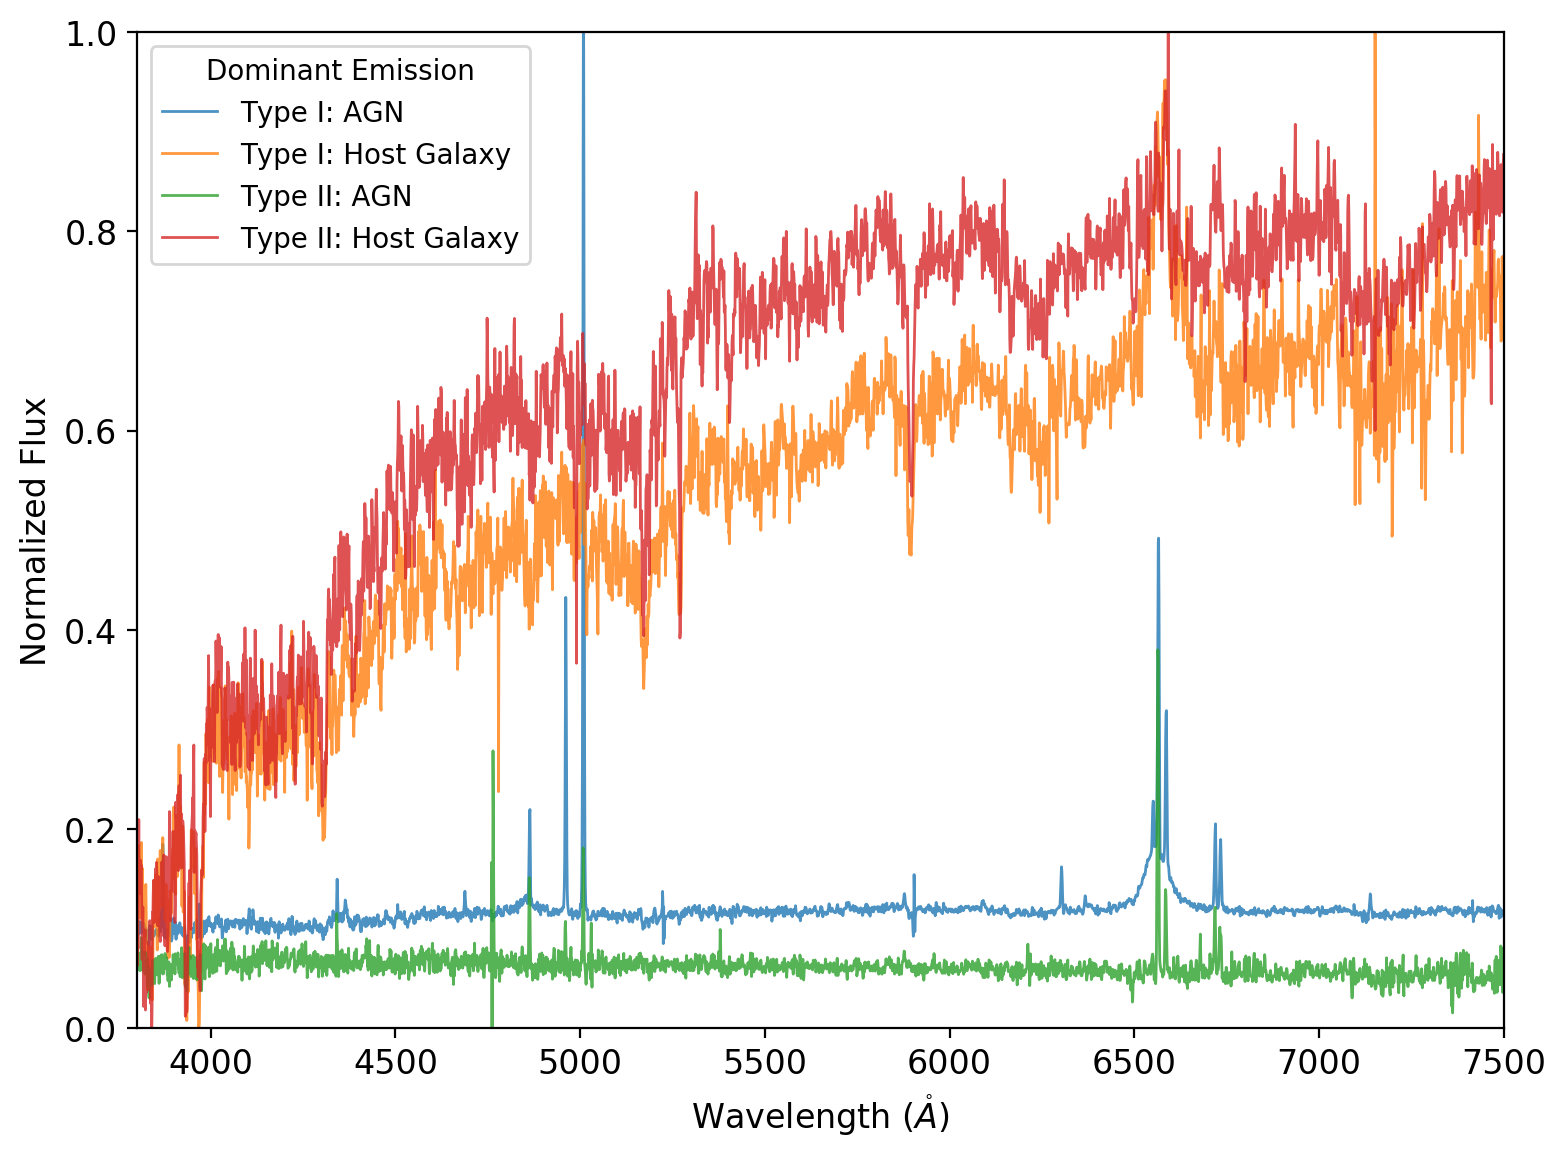

In [75]:
fig = plt.figure(figsize=(8,6))
plotData(type1_feature[type1_min_index]+0.08, alpha=0.8,label='Type I: AGN')
plotData(type1_feature[type1_max_index], alpha=0.8,label='Type I: Host Galaxy')
plotData(type2_feature[type2_min_index]-0.62, alpha=0.8, label='Type II: AGN')
plotData(type2_feature[type2_max_index], alpha=0.8,label='Type II: Host Galaxy')
leg=plt.legend(title='Dominant Emission',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
plt.xlim(3800,7500)
plt.ylim(0,1)
plt.xlabel('Wavelength ($\mathring{A}$)',fontsize=12)
plt.ylabel('Normalized Flux',fontsize=12)

fig.tight_layout()
plt.savefig('dominant_spectrum.pdf', format='pdf')

# Average Spectrum

In [118]:
type1_mean_filtered=torch.mean(type1_feature_filtered,dim=0,keepdim=False)
type2_mean_filtered=torch.mean(type2_feature_filtered,dim=0,keepdim=False)

type1_mean=torch.mean(type1_feature,dim=0,keepdim=False)
type2_mean=torch.mean(type2_feature,dim=0,keepdim=False)

type1_mean_raw=torch.mean(type1_feature_raw,dim=0,keepdim=False)
type2_mean_raw=torch.mean(type2_feature_raw,dim=0,keepdim=False)

Text(0, 0.5, 'Flux ($10^{-17}erg$ $cm^{-2}$$s^{-1}$$\\mathring{A}^{-1}$)')

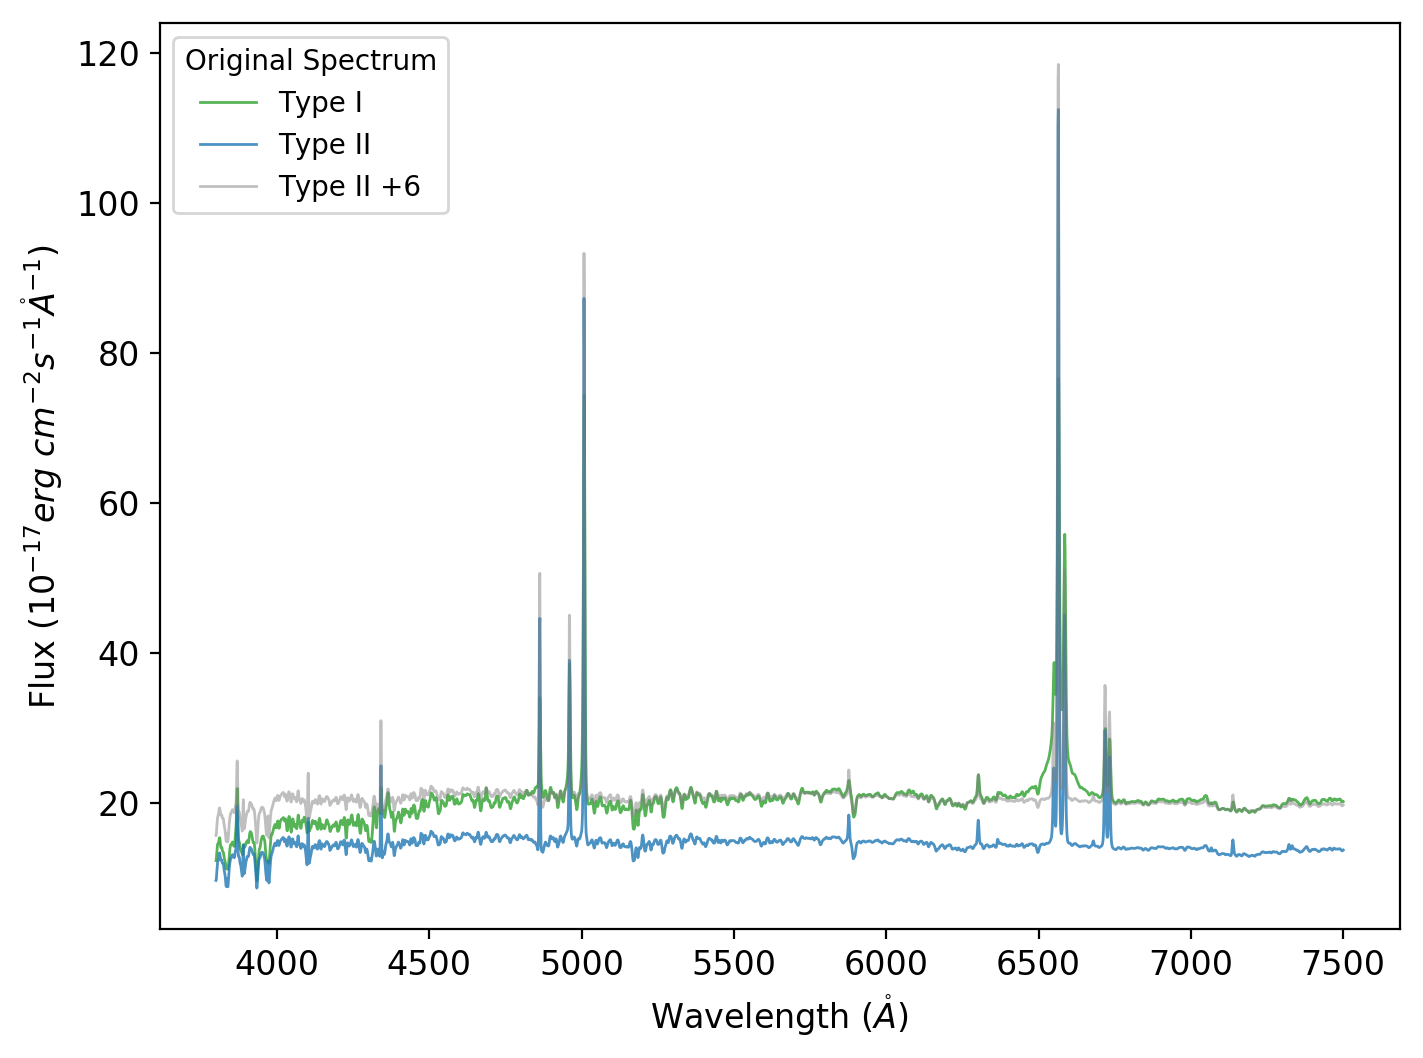

In [15]:
#plotData(sy19_mean,label='Syfert 1s')
#plotData(sy2_mean,label='Syfert 2')

plotData(type1_mean_raw, color='C2', alpha=0.8, linewidth=1, label='Type I')
plotData(type2_mean_raw, color='C0',alpha=0.8, linewidth=1, label='Type II')
plotData(type2_mean_raw+6, color='grey',alpha=0.5, label='Type II +6')


leg=plt.legend(title='Original Spectrum',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
#plt.xlim(3800,7500)
plt.xlabel('Wavelength ($\mathring{A}$)',fontsize=12)
plt.ylabel('Flux ($10^{-17}erg$ $cm^{-2}$$s^{-1}$$\mathring{A}^{-1}$)',fontsize=12)

Text(0, 0.5, 'Normalized Flux')

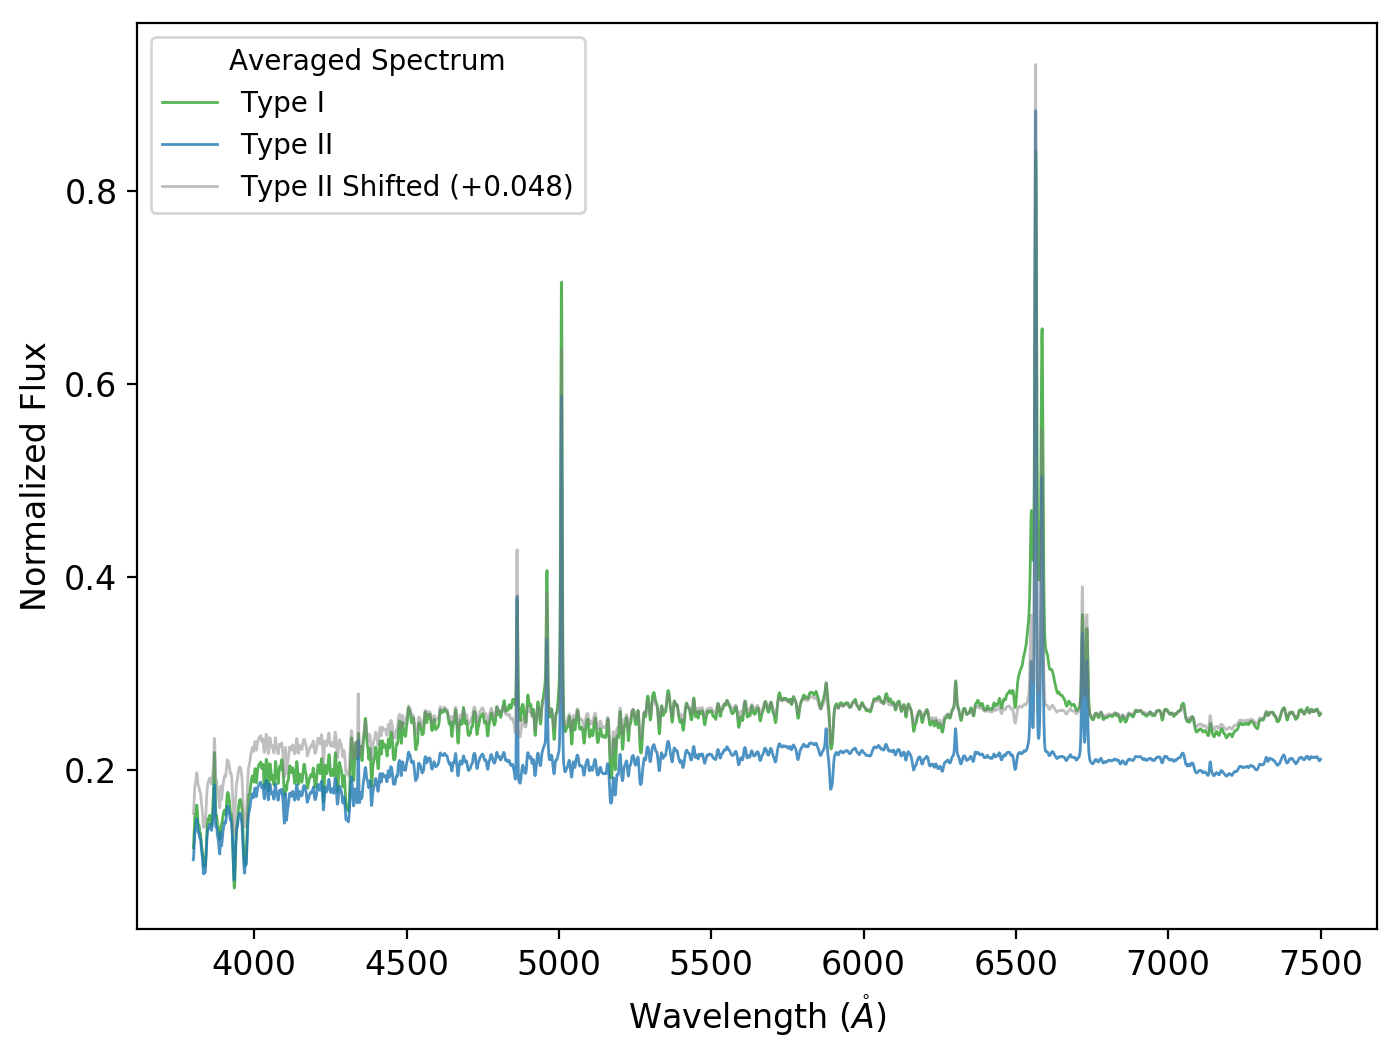

In [17]:
#plotData(sy19_mean,label='Syfert 1s')
#plotData(sy2_mean,label='Syfert 2')

plotData(type1_mean, color='C2', alpha=0.8, label='Type I')
plotData(type2_mean, color='C0',alpha=0.8, label='Type II')
plotData(type2_mean+0.048, color='grey',alpha=0.5, label='Type II Shifted (+0.048)')


leg=plt.legend(title='Averaged Spectrum',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
#plt.xlim(3800,7500)
plt.xlabel('Wavelength ($\mathring{A})$',fontsize=12)
plt.ylabel('Normalized Flux',fontsize=12)

Text(0, 0.5, 'Normalized Flux')

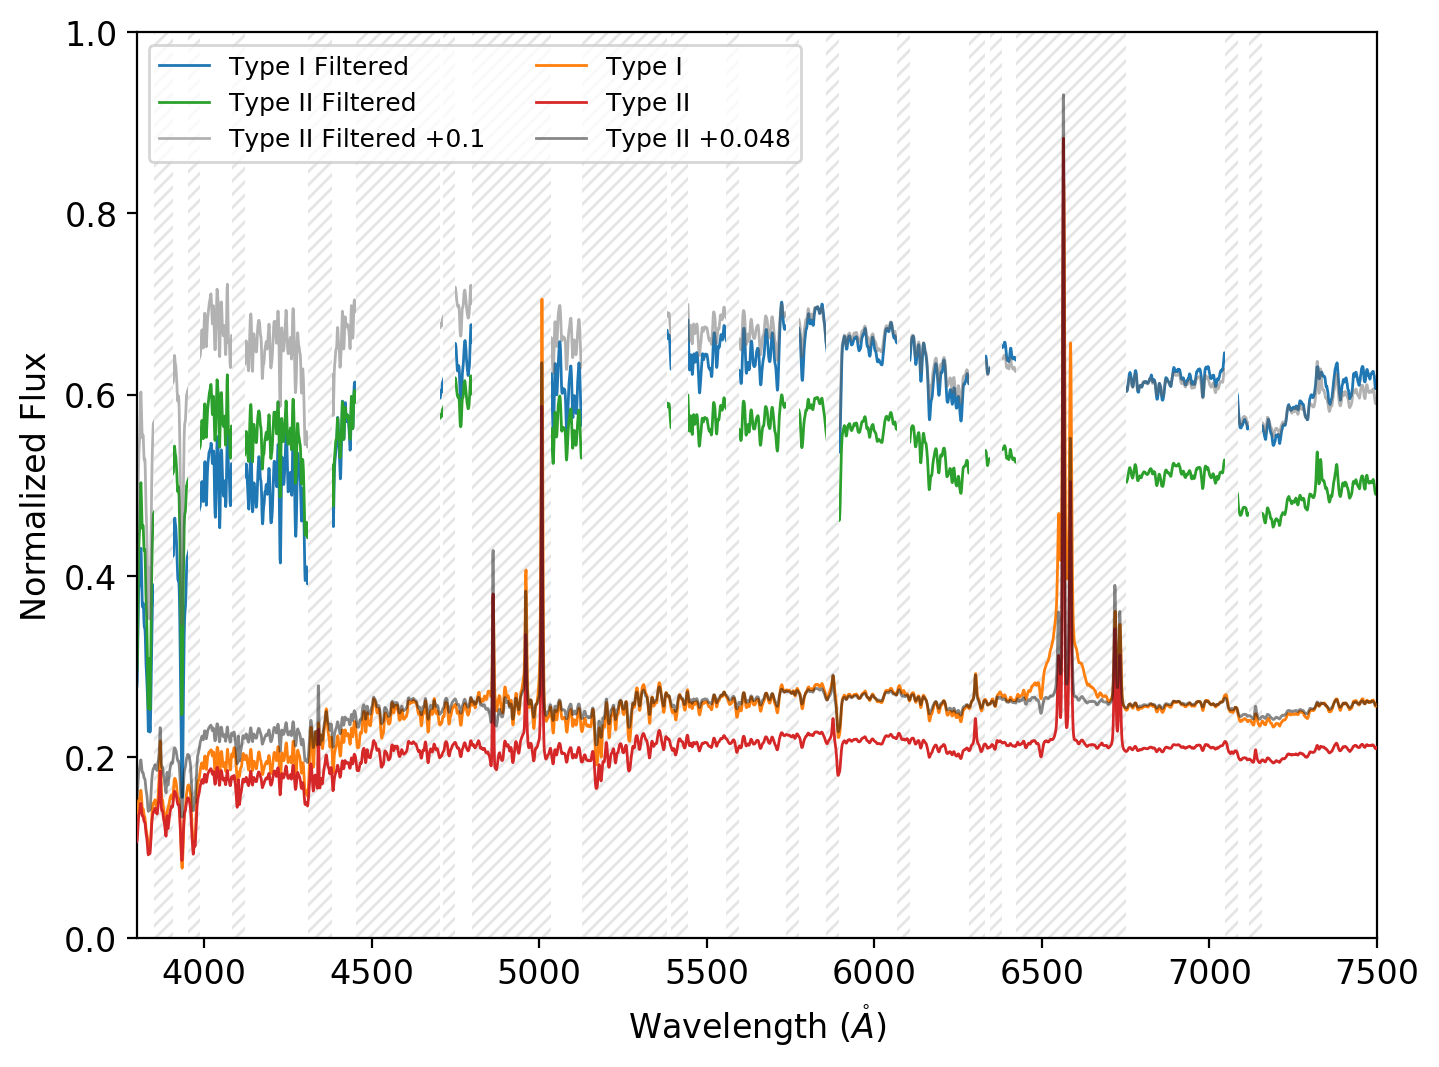

In [23]:
#plotData(sy19_mean,label='Syfert 1s')
#plotData(sy2_mean,label='Syfert 2')

filteredWavelengths= pd.read_csv('../wavelenght-lines-filtered.csv', header=0, comment='#')['wavelength']
filters= pd.read_csv('../lines-filtered.csv', names=['left','right'], comment='#')


plotData(type1_mean_filtered, wavelengths = filteredWavelengths, color='C0', alpha=1, label='Type I Filtered',zorder=1)
plotData(type2_mean_filtered, wavelengths = filteredWavelengths, color='C2',alpha=1, label='Type II Filtered',zorder=1)
plotData(type2_mean_filtered+0.1, wavelengths = filteredWavelengths, color='#666666',alpha=0.5, label='Type II Filtered +0.1',zorder=1)

plotData(type1_mean, color='C1', alpha=1, label='Type I',zorder=3)
plotData(type2_mean, color='C3',alpha=1, label='Type II',zorder=3)
plotData(type2_mean+0.048, color='#111111',alpha=0.5, label='Type II +0.048',zorder=3)

for i in range(len(filters)-1):
    plt.axvspan(filters['right'][i], filters['left'][i+1], facecolor='#ffffff', alpha=1, hatch='/////',edgecolor='#e5e5e5',linewidth=0, zorder=2)
    

leg=plt.legend(fontsize=9,loc='upper left',ncol=2)
plt.setp(leg.get_title(),fontsize=9)

plt.xlim(3800,7500)
plt.ylim(0,1)
plt.xlabel('Wavelength ($\mathring{A})$',fontsize=12)
plt.ylabel('Normalized Flux',fontsize=12)

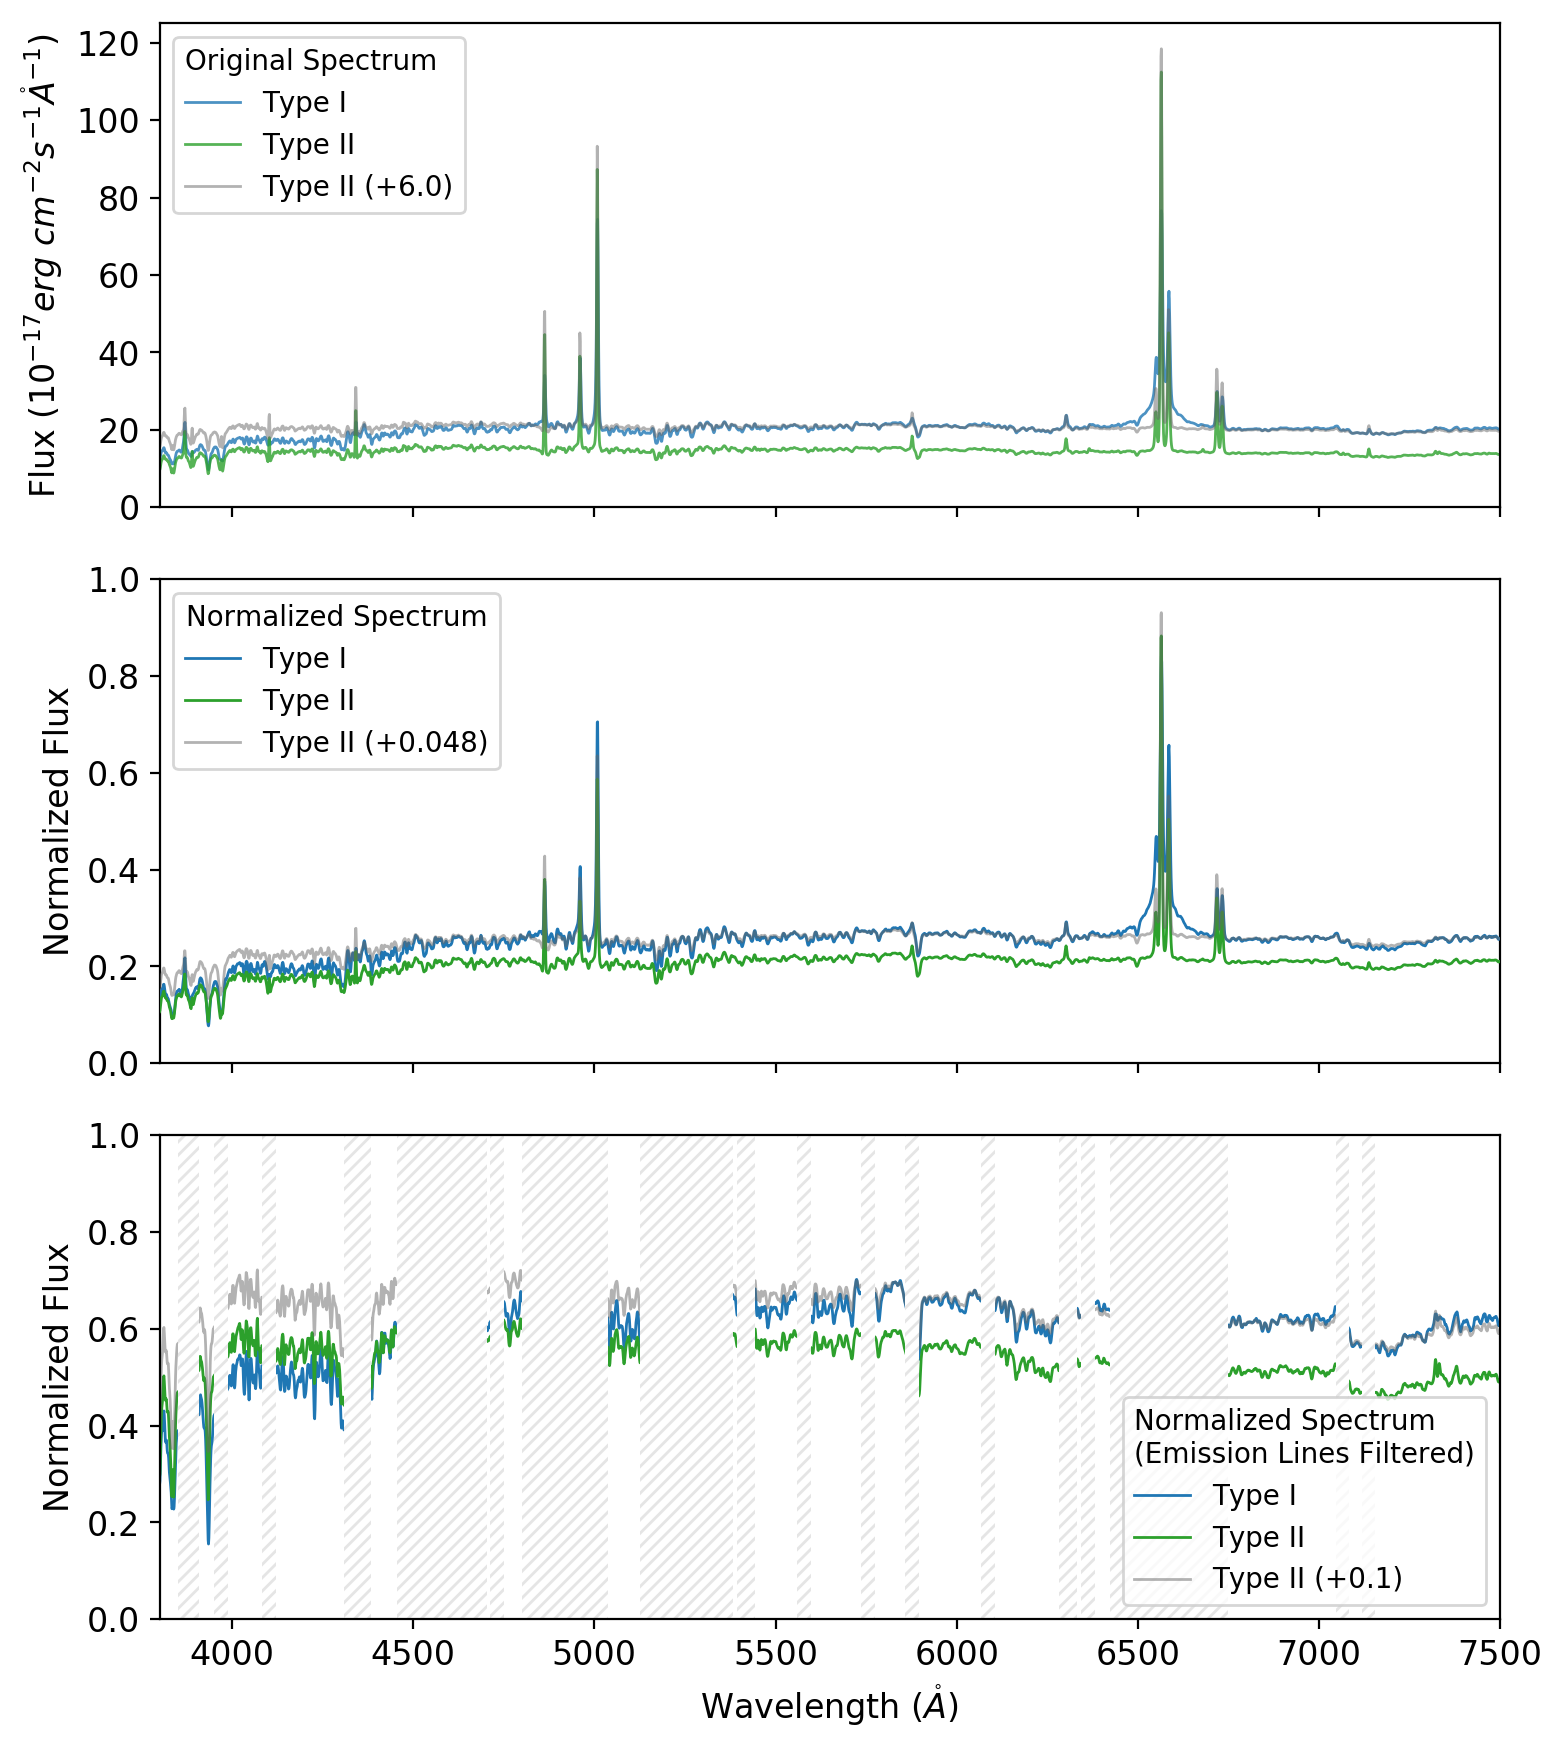

In [134]:
#f, axs = plt.subplots(2,1,figsize=(8,10.67))
#plt.subplots_adjust(hspace = 0.0, wspace=0.05)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,9), sharey=False)
plt.subplots_adjust(hspace=0.05, wspace = 0.05)

################## Original Spectrum ################
ax1 = plt.subplot(311)
plt.setp(ax1.get_xticklabels(), visible=False)
plotData(type1_mean_raw, color='C0', alpha=0.8, linewidth=1, label='Type I')
plotData(type2_mean_raw, color='C2',alpha=0.8, linewidth=1, label='Type II')
plotData(type2_mean_raw+6, color='#666666',alpha=0.5, label='Type II (+6.0)')

plt.ylabel('Flux ($10^{-17}erg$ $cm^{-2}$$s^{-1}$$\mathring{A}^{-1}$)',fontsize=12)
leg=plt.legend(title='Original Spectrum',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
leg._legend_box.align = "left"
plt.ylim(0,125)

################## Normalized Spectrum ################
ax2 = plt.subplot(312, sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
plotData(type1_mean, color='C0', alpha=1, label='Type I',zorder=3)
plotData(type2_mean, color='C2',alpha=1, label='Type II',zorder=3)
plotData(type2_mean+0.048, color='#666666',alpha=0.5, label='Type II (+0.048)',zorder=3)

plt.ylabel('Normalized Flux',fontsize=12)
leg=plt.legend(title='Normalized Spectrum',fontsize=10,loc=2)
plt.setp(leg.get_title(),fontsize=10)
plt.ylim(0,1)

################## Filtered Normalized Spectrum ################
ax3 = plt.subplot(313, sharex=ax1)
filteredWavelengths= pd.read_csv('../wavelenght-lines-filtered.csv', header=0, comment='#')['wavelength']
filters= pd.read_csv('../lines-filtered.csv', names=['left','right'], comment='#')
plotData(type1_mean_filtered, wavelengths = filteredWavelengths, color='C0', alpha=1, label='Type I',zorder=1)
plotData(type2_mean_filtered, wavelengths = filteredWavelengths, color='C2',alpha=1, label='Type II',zorder=1)
plotData(type2_mean_filtered+0.1, wavelengths = filteredWavelengths, color='#666666',alpha=0.5, label='Type II (+0.1)',zorder=1)
for i in range(len(filters)-1):
    plt.axvspan(filters['right'][i], filters['left'][i+1], facecolor='#ffffff', alpha=1, hatch='/////',edgecolor='#e5e5e5',linewidth=0, zorder=2)
plt.ylabel('Normalized Flux',fontsize=12)
leg=plt.legend(title='Normalized Spectrum\n(Emission Lines Filtered)',fontsize=10,loc=4)
leg._legend_box.align = "left"
plt.setp(leg.get_title(),fontsize=10)
plt.ylim(0,1)

plt.xlim(3800,7500)
plt.xlabel('Wavelength ($\mathring{A}$)',fontsize=12)

fig.tight_layout()
plt.savefig('average_spectra.pdf', format='pdf')

In [119]:
len(type1_mean_filtered)

2021